In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [137]:
df = yf.download(tickers = "FROTO.IS",
                 start = "2016-01-01",
                 end= "2022-10-19",
                 interval="1d",
                 group_by="ticker",
                 auto_adjust=True,
                 treads=True)

[*********************100%***********************]  1 of 1 completed


In [138]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-01 00:00:00+02:00,20.329798,20.329798,20.329798,20.329798,0
2016-01-04 00:00:00+02:00,20.141811,20.464079,19.779258,20.370085,282258
2016-01-05 00:00:00+02:00,20.477509,20.571503,19.792687,20.343229,324771
2016-01-06 00:00:00+02:00,20.276089,20.531218,20.074670,20.396938,373568
2016-01-07 00:00:00+02:00,20.289518,20.477509,19.819543,20.437225,546437


In [139]:
df["froto"] = df.Close
df["volume"] = df.Volume
del df["Open"], df["High"], df["Close"], df["Volume"], df["Low"]

In [140]:
df.head()

,froto,volume
Date,,
2016-01-01 00:00:00+02:00,20.329798,0
2016-01-04 00:00:00+02:00,20.370085,282258
2016-01-05 00:00:00+02:00,20.343229,324771
2016-01-06 00:00:00+02:00,20.396938,373568
2016-01-07 00:00:00+02:00,20.437225,546437


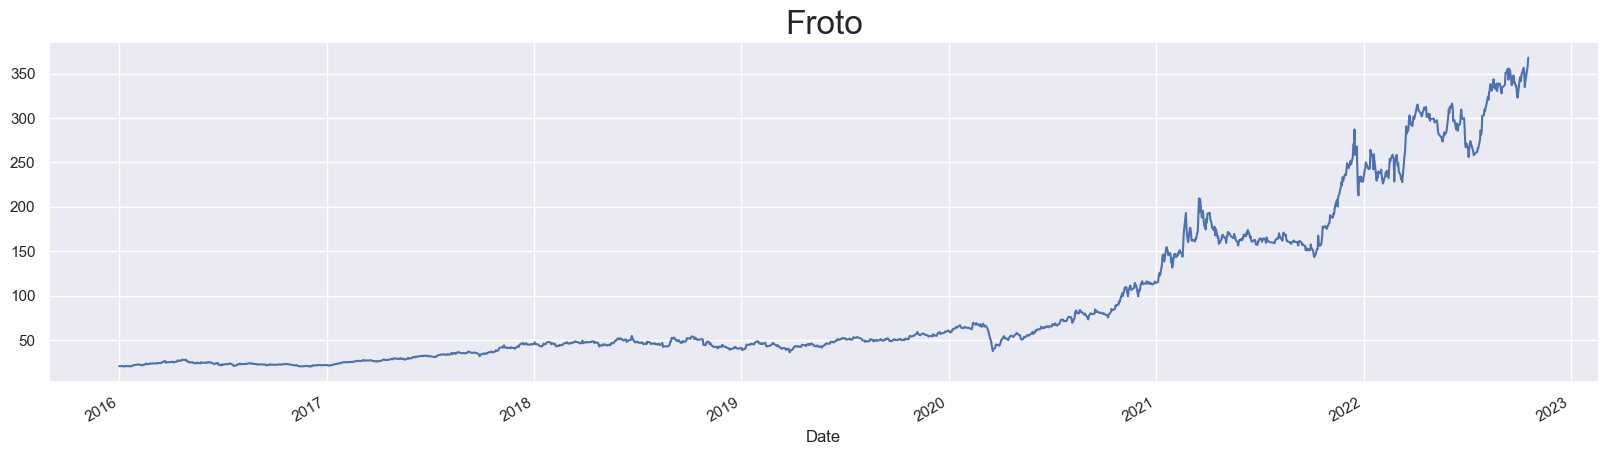

In [141]:
df.froto.plot(figsize = (20,5))
plt.title("Froto", size = 24)
plt.show()

In [142]:
df.isnull().sum()

froto     0
volume    0
dtype: int64

In [143]:
df.froto = df.froto.asfreq('b')

In [144]:
df.isnull().sum()

froto     0
volume    0
dtype: int64

In [145]:
df = df.fillna(method="ffill")

In [146]:
df.isnull().sum()

froto     0
volume    0
dtype: int64

In [147]:
sts.adfuller(df.froto)

(2.0972100350678353,
 0.9987866866882908,
 3,
 1738,
 {'1%': -3.4341181153766156,
  '5%': -2.863204412766938,
  '10%': -2.5676560852851247},
 9345.944910802005)

In [148]:
#s_dec_multiplicative = seasonal_decompose(df.froto, model = "multiplicative")
#s_dec_multiplicative.plot()
#plt.show()

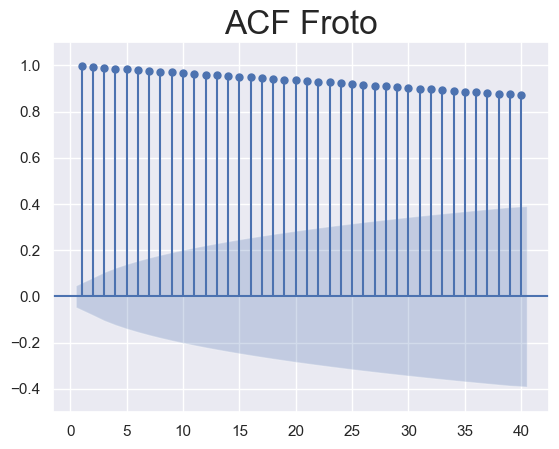

In [149]:
sgt.plot_acf(df.froto, lags = 40, zero = False)
plt.title("ACF Froto", size = 24)
plt.ylim(-0.5,1.1)
plt.show()

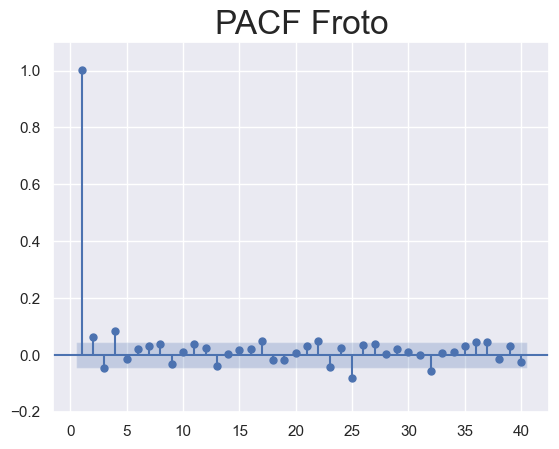

In [150]:
sgt.plot_pacf(df.froto, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Froto", size = 24)
plt.ylim(-0.2,1.1)
plt.show()

In [151]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [152]:
df['returns'] = df.froto.pct_change(1)*100

In [153]:
model_ar_1_i_1_ma_1 = ARIMA(df.froto, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  froto   No. Observations:                 1742
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4729.543
Date:                Thu, 20 Oct 2022   AIC                           9465.085
Time:                        20:31:08   BIC                           9481.472
Sample:                             0   HQIC                          9471.144
                               - 1742                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8339      0.039    -21.473      0.000      -0.910      -0.758
ma.L1          0.7772      0.042     18.335      0.000       0.694       0.860
sigma2        13.3998      0.162     82.706      0.000      13.082      13.717
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             14001.73
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):             139.14   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

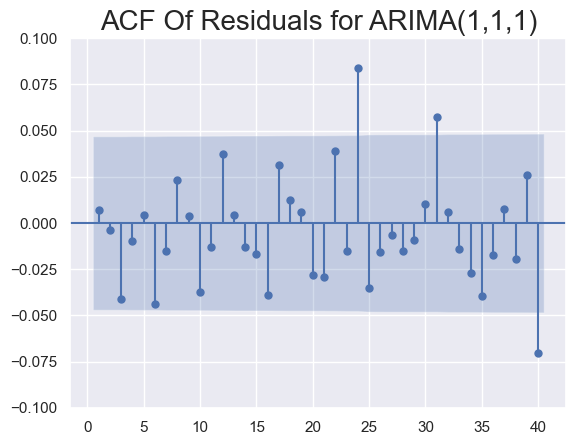

In [154]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.ylim(-0.1,0.1)
plt.show()

In [155]:
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  froto   No. Observations:                 1742
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4729.543
Date:                Thu, 20 Oct 2022   AIC                           9465.085
Time:                        20:31:09   BIC                           9481.472
Sample:                             0   HQIC                          9471.144
                               - 1742                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8339      0.039    -21.473      0.000      -0.910      -0.758
ma.L1          0.7772      0.042     18.335      0.000       0.694       0.860
sigma2        13.3998      0.162     82.706      0.000      13.082      13.717
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             14001.73
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):             139.14   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [156]:
df['delta_prices']=df.froto.diff(1)

In [157]:
model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1))
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
results_delta_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 1741
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4726.773
Date:                Thu, 20 Oct 2022   AIC                           9461.546
Time:                        20:31:09   BIC                           9483.395
Sample:                             0   HQIC                          9469.625
                               - 1741                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1999      0.085      2.352      0.019       0.033       0.367
ar.L1         -0.8305      0.039    -21.171      0.000      -0.907      -0.754
ma.L1          0.7727      0.043     18.025      0.000       0.689       0.857
sigma2        13.3571      0.161     82.884      0.000      13.041      13.673
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):             13999.01
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):             127.46   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
sts.adfuller(df.delta_prices[1:])

(-25.461796976706,
 0.0,
 2,
 1738,
 {'1%': -3.4341181153766156,
  '5%': -2.863204412766938,
  '10%': -2.5676560852851247},
 9343.80482568875)

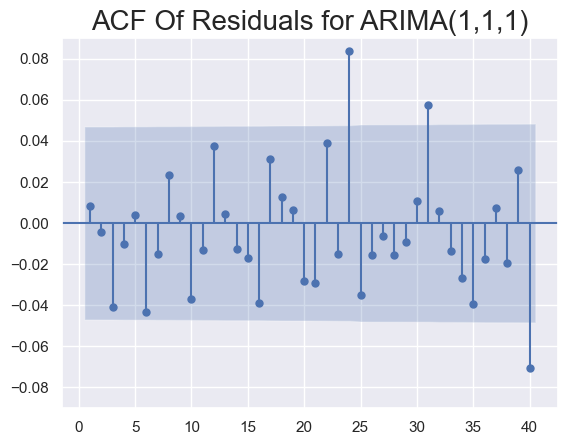

In [159]:
df['results_delta_ar_1_i_1_ma_1'] = results_delta_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.results_delta_ar_1_i_1_ma_1[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20),
plt.ylim(-0.09,0.09)
plt.show()

In [160]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [161]:
model_sarimax = SARIMAX(df.froto, exog = df.volume, order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             froto   No. Observations:                 1742
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood               -8344.148
Date:                           Thu, 20 Oct 2022   AIC                          16702.295
Time:                                   20:31:11   BIC                          16740.535
Sample:                                        0   HQIC                         16716.434
                                          - 1742                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume     -2.537e-06   3.61e-06     -0.702      0.483   -9.62e-06    4.54e-06
ar.L1          0.9431      0.171      5.508      0.000       0.607       1.279
ma.L1         -0.4991      0.527     -0.946      0.344      -1.533       0.535
ar.S.L5        0.7635      2.224      0.343      0.731      -3.595       5.122
ar.S.L10       0.0400      1.320      0.030      0.976      -2.546       2.626
ma.S.L5       -0.4567      2.148     -0.213      0.832      -4.667       3.754
sigma2      2238.4442      0.007   3.15e+05      0.000    2238.430    2238.458
===================================================================================
Ljung-Box (L1) (Q):                 686.55   Jarque-Bera (JB):              8073.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              64.32   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.42e+21. Standard errors may be unstable.
"""